In [1]:
import numpy as np
import pandas as pd
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")
import scipy as sp
from IPython import embed as shell
import psychofit as psy
# import tqdm # progress bar

In [2]:
#### Urai et al. (2018): pupil dilation and reaction times scale with decision uncertainty ####
try:
    data_urai2017 = pd.read_csv('https://ndownloader.figshare.com/files/12753785')
    data_urai2017['choice']        = data_urai2017.resp
    data_urai2017['evidence']      = data_urai2017.coherence * data_urai2017.stimulus # signed evidence
    data_urai2017['subj_idx']      = data_urai2017.subjnr

except:
    data_urai2017 = pd.read_csv('/Users/urai/Data/HDDM/NatComm/2ifc_data_hddm.csv')
    data_urai2017['choice']        = np.sign(data_urai2017.response - 0.1)
    data_urai2017['evidence']      = data_urai2017.stimulus
    data_urai2017['sessionnr']     = data_urai2017.session
    data_urai2017['blocknr']       = data_urai2017.block
    data_urai2017['correct']       = 1 * (np.sign(data_urai2017.stimulus) == data_urai2017.choice)
    data_urai2017['decision_pupil'] = data_urai2017.prevpupil.shift(-1)
    
data_urai2017['coherence'].values[data_urai2017['coherence'] <= 0.025] =  0.025
data_urai2017['coherence'] = data_urai2017['coherence'] * 100
data_urai2017['evidence'] = data_urai2017['coherence'] * np.sign(data_urai2017.stimulus)

In [3]:
# normalize RT for each participant
zscore = lambda x: (x - x.mean()) / x.std()
data_urai2017['rt_norm'] = data_urai2017.groupby(['subj_idx', 'sessionnr', 'blocknr'])['rt'].transform(zscore)
data_urai2017['evidence_norm'] = data_urai2017.groupby(['subj_idx', 'sessionnr', 'blocknr'])['evidence'].transform(zscore)
data_urai2017['coherence_norm'] = data_urai2017.groupby(['subj_idx', 'sessionnr', 'blocknr'])['coherence'].transform(zscore)
data_urai2017['decision_pupil'] = data_urai2017.groupby(['subj_idx', 'sessionnr', 'blocknr'])['decision_pupil'].transform(zscore)

data_urai2017.sample(n=10)

,subj_idx,session,block,trial,stimulus,coherence,response,rt,prevstim,prevresp,...,prev3pupil,choice,evidence,sessionnr,blocknr,correct,decision_pupil,rt_norm,evidence_norm,coherence_norm
17802,8,3,3,31,0.0125,2.5,1,0.58,-1,-1,...,0.681825,1.0,2.5,3,3,1,1.232506,-1.019200,0.087208,-0.596708
14769,7,1,9,42,-0.2000,20.0,0,1.20,1,1,...,3.022348,-1.0,-20.0,1,9,1,0.691094,1.898941,-1.104976,0.620878
7266,4,1,2,43,0.1000,10.0,1,0.74,1,1,...,0.227225,1.0,10.0,1,2,1,-0.378338,-1.320512,0.584758,-0.029546
55669,24,2,9,26,-0.1000,10.0,0,0.37,-1,-1,...,-0.128606,-1.0,-10.0,2,9,1,0.238893,-1.380397,-0.528224,-0.359554
5427,3,2,4,24,0.0250,2.5,0,1.38,-1,1,...,-0.659864,-1.0,2.5,2,4,0,-1.264919,2.550715,0.102046,-0.731452
12843,6,2,9,34,-0.0500,5.0,0,0.34,-1,-1,...,0.178547,-1.0,-5.0,2,9,1,1.110278,-1.314835,-0.348600,-0.463453
934,1,2,10,26,0.1000,10.0,0,0.73,1,1,...,-0.316198,-1.0,10.0,2,10,0,1.566764,0.724995,0.514306,0.010457
13552,6,4,4,23,-0.0250,2.5,1,0.55,-1,1,...,0.509073,1.0,-2.5,4,4,0,0.313625,-0.623209,-0.370100,-0.719794
55576,24,2,7,29,-0.3000,30.0,0,0.34,-1,-1,...,0.728511,-1.0,-30.0,2,7,1,-0.002615,-1.264550,-1.612768,1.582237
28370,12,5,4,39,0.0500,5.0,0,0.85,1,1,...,0.214554,-1.0,5.0,5,4,0,-0.884429,1.914038,0.334233,-0.230499


/anaconda3/envs/python3.7/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


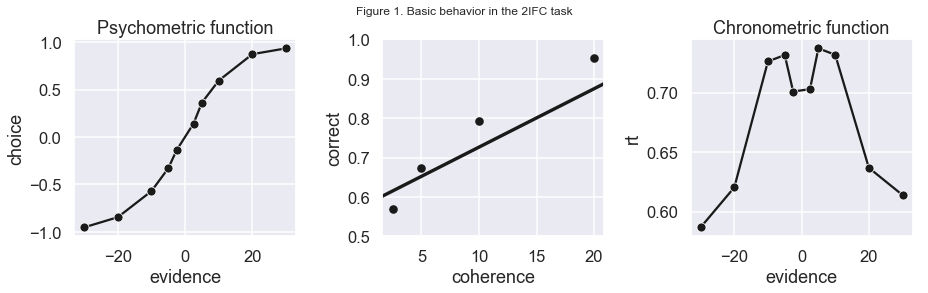

In [4]:
## FIRST, MAKE A QUICK OVERVIEW OF BASIC BEHAVIORAL DATA
fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(data=data_urai2017, x='evidence', y='choice', color='k', marker='o', ci=None,  ax=ax[0])
ax[0].set(title='Psychometric function')
sns.regplot(data=data_urai2017, x='coherence', y='correct', x_bins=5, color='k', marker='o', ci=None, ax=ax[1])
ax[1].set(ylim=[0.5, 1])
sns.lineplot(data=data_urai2017, x='evidence', y='rt', color='k', marker='o', ci=None,ax=ax[2])
ax[2].set(title='Chronometric function')
fig.suptitle('Figure 1. Basic behavior in the 2IFC task', verticalalignment='baseline')
plt.tight_layout()

In [52]:
## RT reflects uncertainty
data_urai2017.loc[:,'rt_bin'] = pd.qcut(data_urai2017['rt_norm'], 2, labels=False) # median split

fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(data=data_urai2017, x='evidence', y='rt_norm', hue='correct', marker='o', ax=ax[0], ci=None, palette={0:"firebrick", 1:"forestgreen"}, legend=False)
ax[0].set(title='Vevaiometric curve')
sns.regplot(data=data_urai2017, x='rt_norm', y='correct', x_bins=5, color='k', marker='o', ax=ax[1], ci=None)
ax[1].set(title='Confidence calibration')
sns.lineplot(data=data_urai2017, x='coherence', y='correct', hue='rt_bin', marker='o',ci=None, ax=ax[2], palette={0:"dimgrey", 1:"black"}, legend=False)
ax[2].set(title='Conditional psychometric', ylim=[0.5, 1])
fig.suptitle('Figure 2. Reaction time reflects uncertainty', verticalalignment='baseline')
plt.tight_layout()
fig.savefig('rt.pdf')

<Figure size 936x288 with 3 Axes>


In [53]:
## Pupil reflects uncertainty
data_urai2017.loc[:,'pupil_bin'] = pd.qcut(data_urai2017['decision_pupil'], 2, labels=False) # median split

fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(data=data_urai2017, x='evidence', y='decision_pupil', hue='correct', marker='o', ci=None, ax=ax[0], palette={0:"firebrick", 1:"forestgreen"}, legend=False)
ax[0].set(title='Vevaiometric curve')
sns.regplot(data=data_urai2017, x='decision_pupil', y='correct', x_bins=5, color='k', marker='o', ax=ax[1], ci=None)
ax[1].set(title='Confidence calibration')
sns.lineplot(data=data_urai2017, x='coherence', y='correct', hue='pupil_bin', marker='o', ci=None, ax=ax[2], palette={0:"dimgrey", 1:"black"}, legend=False)
ax[2].set(title='Conditional psychometric', ylim=[0.5, 1])
fig.suptitle('Figure 3. Post-decision pupil dilation reflects uncertainty', verticalalignment='baseline')
plt.tight_layout()
fig.savefig('pupil.pdf')

<Figure size 936x288 with 3 Axes>


In [54]:
# RATHER THAN FITTING PSYCHOMETRIC FUNCTION SHIFTS, DO A QUICK HEURISTIC: REPETITION PROBABILITY
data_urai2017['repeat']              = 1 * (data_urai2017['choice'] == data_urai2017.choice.shift(1))
data_urai2017['previous_coherence']  = data_urai2017.coherence.shift(1)
data_urai2017['previous_choice']     = data_urai2017.choice.shift(1)
data_urai2017['previous_correct']    = data_urai2017.correct.shift(1)
data_urai2017['previous_rt_bins']    = pd.qcut(data_urai2017.rt_norm.shift(1), 3, labels=False) 
data_urai2017['previous_pupil_bins'] = pd.qcut(data_urai2017.decision_pupil.shift(1), 3, labels=False) 
# data_urai2017.loc[:,'current_evidence'] = pd.qcut(data_urai2017['coherence'], 2, labels=False) # median split

In [55]:
## DEFINE UPDATING BASED ON THE PSYCHOMETRIC FUNCTION SHIFT
# from ibl_pipeline.analyses import behavior as behavioral_analyses

def fit_psychfunc(df):
    
    choicedat = df.dropna(subset=['choice']) # ignore missed trials
    choicedat = choicedat.groupby('evidence').agg({'rt':'count', 'response':'mean'}).reset_index()  
    assert(all(choicedat['response'] >= 0)) # make sure we're not using signed choices
    
    if sum(choicedat.rt) > 100: # only fit if each datapoint has at least 10 trials
        pars, L = psy.mle_fit_psycho(choicedat.values.transpose(), P_model='erf_psycho', 
            parstart=np.array([choicedat['evidence'].mean(), 20., 0.05]), 
            parmin=np.array([choicedat['evidence'].min(), 0., 0.]), 
            parmax=np.array([choicedat['evidence'].max(), 100., 1.]))
        df2 = {'bias':pars[0],'threshold':pars[1], 'lapse':pars[2]}
    else:
        df2 = {'bias':np.nan, 'threshold':np.nan, 'lapse':np.nan}
    return pd.DataFrame(df2, index=[0])

def updating(df, colname):
    
    # fit psychometric functions
    psychfuncfits = df.groupby(['subj_idx', 'previous_choice', 'previous_correct', colname]).apply(fit_psychfunc).reset_index()    
    
    
    # make a new dataframe to compute the bias shift per group
    df2 = pd.DataFrame()
    for name, grouped in psychfuncfits.groupby(['previous_correct', 'subj_idx', colname]):
        if grouped.shape[0] == 2: # skip if there aren't 2 previous responses in this bin
            biasshift = grouped.loc[grouped.previous_choice == -1, 'bias'].item() - grouped.loc[grouped.previous_choice == 1, 'bias'].item()
            df3 = grouped.groupby(['previous_correct', 'subj_idx', colname]).mean().reset_index() # average the rest
            df3['update'] = biasshift # now insert the computed biasshift
            df2 = df2.append(df3)
            
    print(colname)
    df2 = df2.dropna(subset=['update'])
    # print(df2.columns)
    return df2


In [ ]:
## NOW FIT THE PSYCHOMETRIC FUNCTION SHIFT, DEPENDING ON PREVIOUS COHERENCE
coherence_update = updating(data_urai2017, 'previous_coherence')
pupil_update     = updating(data_urai2017, 'previous_pupil_bins')
rt_update        = updating(data_urai2017, 'previous_rt_bins')

In [68]:
## HOW DO PUPIL, RT AND COHERENCE AFFECT NEXT-TRIAL UPDATING?
fig, ax = plt.subplots(1, 3, figsize=(13,4), sharey=True)
kwargs = {'y':'update', 'hue':"previous_correct", 'ci':68, 'marker':'o', 'estimator':np.nanmean, 'err_style':"bars", 
           'palette':{0:"firebrick", 1:"forestgreen"}, 'legend':False}
sns.lineplot(data=coherence_update[coherence_update.previous_correct == 1], x='previous_coherence',  ax=ax[0], **kwargs)
sns.lineplot(data=rt_update[rt_update.previous_correct == 1], x='previous_rt_bins', ax=ax[1], **kwargs)
sns.lineplot(data=pupil_update[pupil_update.previous_correct == 1], x='previous_pupil_bins', ax=ax[2], **kwargs)
fig.suptitle('Figure 4. Decision uncertainty reduces repetition', verticalalignment='baseline')
plt.tight_layout()
fig.savefig('updating.pdf')

<Figure size 936x288 with 3 Axes>
